### Import Statement

In [ ]:
import pandas as pd
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
import statsmodels.api as sns
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
# from google.colab import drive

Notebook Introduction
1. Data Source are from  https://data.boston.gov/dataset/approved-building-permits and https://data.boston.gov/dataset/live-street-address-management-sam-addresses
2. Finding insight and correlation between the two dataset.

Code Processing and data cleaning

In [ ]:
df_permit = pd.read_csv('../data/building_permits.csv', low_memory=False)
df_addy = pd.read_csv('../data/Live_Street_Address_Management_(SAM)_Addresses.csv', low_memory=False)

In [ ]:
df_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617698 entries, 0 to 617697
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   permitnumber        617698 non-null  object 
 1   worktype            613157 non-null  object 
 2   permittypedescr     617698 non-null  object 
 3   description         613157 non-null  object 
 4   comments            617491 non-null  object 
 5   applicant           608874 non-null  object 
 6   declared_valuation  617698 non-null  object 
 7   total_fees          617698 non-null  object 
 8   issued_date         617698 non-null  object 
 9   expiration_date     592108 non-null  object 
 10  status              617698 non-null  object 
 11  owner               603105 non-null  object 
 12  occupancytype       615769 non-null  object 
 13  sq_feet             617698 non-null  float64
 14  address             610741 non-null  object 
 15  city                617513 non-nul

In [ ]:
df_addy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399908 entries, 0 to 399907
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   X                     399908 non-null  float64
 1   Y                     399908 non-null  float64
 2   SAM_ADDRESS_ID        399908 non-null  int64  
 3   RELATIONSHIP_TYPE     399908 non-null  int64  
 4   BUILDING_ID           399908 non-null  int64  
 5   FULL_ADDRESS          399908 non-null  object 
 6   STREET_NUMBER         399908 non-null  object 
 7   IS_RANGE              399908 non-null  int64  
 8   RANGE_FROM            26158 non-null   object 
 9   RANGE_TO              26158 non-null   object 
 10  UNIT                  268726 non-null  object 
 11  FULL_STREET_NAME      399908 non-null  object 
 12  STREET_ID             399908 non-null  int64  
 13  STREET_PREFIX         399908 non-null  object 
 14  STREET_BODY           399908 non-null  object 
 15  

In [ ]:
# Check for a common column name
common_column = set(df_permit.columns).intersection(df_addy.columns)

# If there is a common column, use it to merge the dataframes
if common_column:
    merged_df = pd.merge(df_permit, df_addy, on=common_column)
else:
    print("No common column found to merge the dataframes.")


No common column found to merge the dataframes.


In [ ]:
# Clean and convert fields
df_permit['declared_valuation'] = df_permit['declared_valuation'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_permit.fillna({'applicant': 'Unknown', 'declared_valuation': df_permit['declared_valuation'].median()}, inplace=True)
df_permit['issued_date'] = pd.to_datetime(df_permit['issued_date'])
df_permit['expiration_date'] = pd.to_datetime(df_permit['expiration_date'])

df_permit['address'] = df_permit['address'].str.lower().str.strip()
df_addy['FULL_ADDRESS'] = df_addy['FULL_ADDRESS'].str.lower().str.strip()

df_permit['merge_key'] = df_permit['address'] + ' ' + df_permit['zip'].astype(str)
df_addy['merge_key'] = df_addy['FULL_ADDRESS'] + ' ' + df_addy['ZIP_CODE'].astype(str)

# Merge the DataFrames
merged_df = pd.merge(df_permit, df_addy, on='merge_key', how='inner')

# Check if the merge resulted in an empty DataFrame
if merged_df.empty:
    print("Merged DataFrame is empty. Check the merge keys for consistency.")
else:
    # Select numeric features for scaling
    numeric_features = merged_df.select_dtypes(include=['int64', 'float64']).columns
    if numeric_features.empty:
        print("No numeric features to scale.")
    else:
        # Apply scaling
        scaler = StandardScaler()
        merged_df[numeric_features] = scaler.fit_transform(merged_df[numeric_features])
        print("Scaling applied successfully.")

/var/folders/h7/dt5rpfzd16v4hscgjq63qwyw0000gn/T/ipykernel_11513/1764580945.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_permit = pd.read_csv('building_permits.csv')
/var/folders/h7/dt5rpfzd16v4hscgjq63qwyw0000gn/T/ipykernel_11513/1764580945.py:3: DtypeWarning: Columns (8,9,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_addy = pd.read_csv('Live_Street_Address_Management_(SAM)_Addresses.csv')


Scaling applied successfully.


In [ ]:
merged_df.head()

,permitnumber,worktype,permittypedescr,description,comments,applicant,declared_valuation,total_fees,issued_date,expiration_date,...,STREET_SUFFIX_DIR,STREET_NUMBER_SORT,MAILING_NEIGHBORHOOD,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL
0,A1000569,INTEXT,Amendment to a Long Form,Interior/Exterior Work,This work is to Amend Permit ALT347244. Elimin...,Patrick Sharkey,-0.026018,$390.00,2021-01-28 16:29:26+00:00,2021-07-28 04:00:00+00:00,...,,-0.078566,Boston,-0.734386,0.897485,0.925196,1.154776,3,0306,303807000
1,A100071,COB,Amendment to a Long Form,City of Boston,Change connector link layout from attached enc...,Renee Santeusanio,-0.025306,$29.00,2011-11-04 15:04:58+00:00,2012-05-04 04:00:00+00:00,...,,-0.092027,West Roxbury,0.146008,-1.772507,-1.932481,-1.251575,20,2003,2012032000
2,A1001012,OTHER,Amendment to a Long Form,Other,Amend Alt943748 to erect a roof deck as per pl...,Jusimar Oliveria,-0.032419,$70.00,2020-06-01 18:08:47+00:00,NaT,...,,-0.450974,Charlestown,0.031174,0.764924,1.389109,0.733733,2,0202,202837000
3,A1001201,INTEXT,Amendment to a Long Form,Interior/Exterior Work,Build steel balcony over garden level with sta...,Andreas Hwang,-0.018337,$803.00,2019-11-13 18:38:56+00:00,2020-05-13 04:00:00+00:00,...,,-0.011264,Roxbury,-0.389884,0.142023,0.384384,1.139615,4,0404,402558000
4,A100137,EXTREN,Amendment to a Long Form,Renovations - Exterior,Landscaping/stonework - amending permit #2801/...,Unknown,-0.030387,$182.00,2013-01-03 19:13:09+00:00,2013-07-03 04:00:00+00:00,...,,-0.453217,Brighton,0.260842,-1.908740,0.493000,1.518622,22,2209,2204944000


## Spatial Analysis and Geographic Information Systems (GIS) Projects

In [ ]:
# Filter data for new housing units. This step assumes 'description' contains relevant keywords for new housing units.
housing_related_keywords = ['housing', 'residential', 'apartment', 'condo']
df_housing = merged_df[merged_df['description'].str.contains('|'.join(housing_related_keywords), case=False, na=False)]

# Step 2: Aggregation
# Aggregating by 'city' and counting permits. Adjust this if you'd rather aggregate by 'zip'
permits_by_city = df_housing.groupby('city').size().reset_index(name='permits_count')

# Sorting the data to find top communities with the highest number of permits
permits_by_city_sorted = permits_by_city.sort_values(by='permits_count', ascending=False)

# Step 3: Analysis
# Display the top 10 cities with the highest number of housing permits
print(permits_by_city_sorted.head(10))



             city  permits_count
4      Dorchester            126
13   South Boston             88
7   Jamaica Plain             30
14   West Roxbury             30
12        Roxbury             24
5     East Boston             22
11     Roslindale             22
2        Brighton             16
8        Mattapan             15
3     Charlestown             14


             city  average_valuation
7   Jamaica Plain          -0.023067
6       Hyde Park          -0.023957
3     Charlestown          -0.027034
12        Roxbury          -0.027271
5     East Boston          -0.027375
14   West Roxbury          -0.029323
0         Allston          -0.030362
2        Brighton          -0.030982
1          Boston          -0.030986
13   South Boston          -0.031728


/var/folders/h7/dt5rpfzd16v4hscgjq63qwyw0000gn/T/ipykernel_11513/3876597545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='permits_count', y='city', data=permits_by_city_sorted.head(10), palette='viridis')


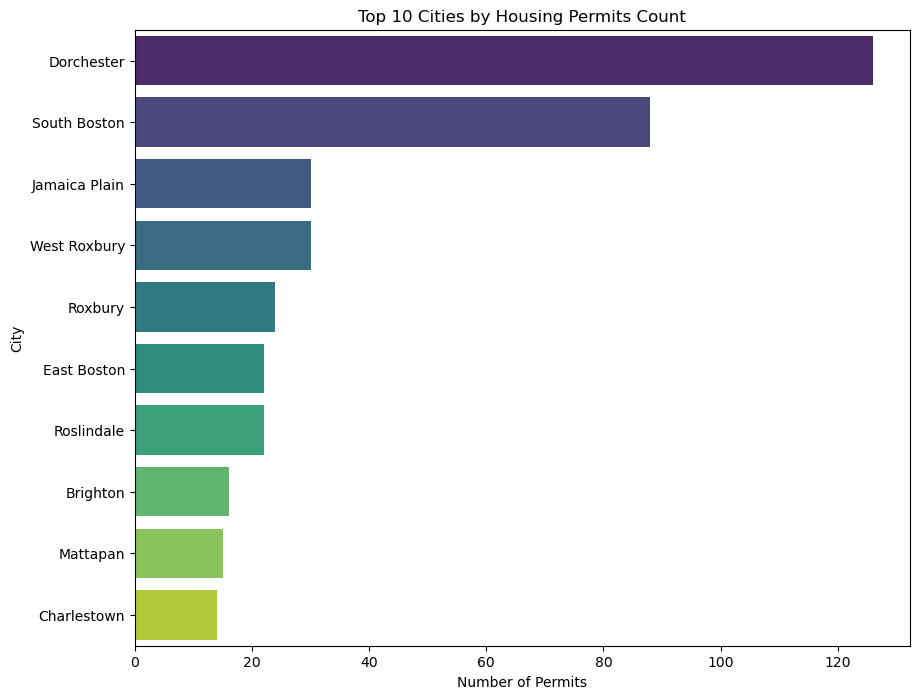

In [ ]:
# Assuming 'declared_valuation' represents the valuation of the project, you can analyze average valuation by city
average_valuation_by_city = df_housing.groupby('city')['declared_valuation'].mean().reset_index(name='average_valuation')
average_valuation_by_city_sorted = average_valuation_by_city.sort_values(by='average_valuation', ascending=False)
print(average_valuation_by_city_sorted.head(10))

# Visualization - Bar plot of the top 10 cities by permit count
plt.figure(figsize=(10, 8))
sns.barplot(x='permits_count', y='city', data=permits_by_city_sorted.head(10), palette='viridis')
plt.title('Top 10 Cities by Housing Permits Count')
plt.xlabel('Number of Permits')
plt.ylabel('City')
plt.show()

## Comments analysis after mid presentation

From the graph of top 10 cities by housing permits it is obvious that the area in Dorchester and South Boston shows a very significant high amount of development compared to other areas. Therefore after these insight we tried to look at the reasons on why or what makes them issued a permit. Reasons are t gether a better understanding and could increase the focus of the housing government to improve the regulations of the new houses are being developed and aspects to improve the living conditions.

In [ ]:
# # Ensure NLTK resources are downloaded
# nltk.download('vader_lexicon')
# nltk.download('stopwords')

Using sentiment analysis to check the most common key words in the comment from the client

   MAILING_NEIGHBORHOOD  \
14           Dorchester   
17           Dorchester   
18           Dorchester   
19           Dorchester   
33           Dorchester   

                                                                                                                                                                                                                                       comments  \
14                                                                                                                                            Amendment to ERT759370. Finishing the basement, creating a bathroom, and adding an office.; eplan   
17                         Bathroom &; Kitchen floor reframing Plans: This drawing was issued to illustrated repairs to existing framing found to be compromised during the course of construction. to amend ALT788293 (see a1006693 for plans)   
18  Amendment to ALT788317. Bathroom &; Kitchen floor reframing Plans: This drawing was issued to illustrate

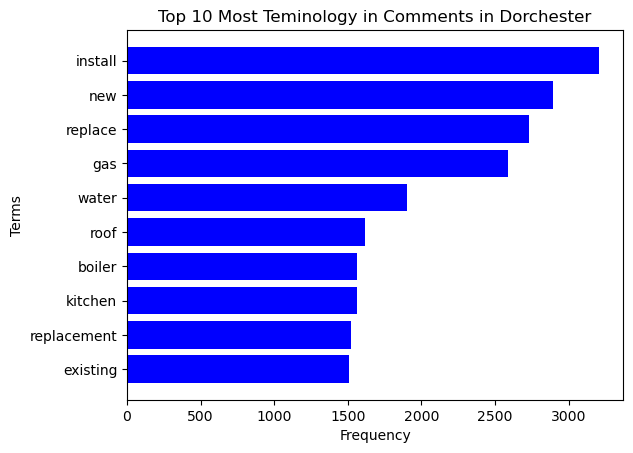

In [ ]:
# Convert all comments to strings (handling NaN values safely)
merged_df['comments'] = merged_df['comments'].astype(str)

# Filter comments from Dorchester and South Boston
comments_df_Dorchester = merged_df[merged_df['MAILING_NEIGHBORHOOD'].isin(['Dorchester'])][['MAILING_NEIGHBORHOOD', 'comments']]

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
comments_df_Dorchester['sentiment'] = comments_df_Dorchester['comments'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Display the sentiment scores
print(comments_df_Dorchester[['MAILING_NEIGHBORHOOD', 'comments', 'sentiment']].head())

# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(comments_df_Dorchester['comments'])

# Singular Value Decomposition for TF-IDF
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10, random_state=42)
svd_matrix = svd_model.fit_transform(tfidf_matrix)

# Plot the 10 most frequent words in the TF-IDF transformed matrix
terms = tfidf_vectorizer.get_feature_names_out()
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking_sorted = ranking.sort_values('rank', ascending=False)
top_terms = ranking_sorted.head(10)

fig, ax = plt.subplots()
ax.barh(top_terms['term'], top_terms['rank'], color='blue')
ax.set_xlabel('Frequency')
ax.set_ylabel('Terms')
ax.set_title('Top 10 Most Teminology in Comments in Dorchester')
plt.gca().invert_yaxis()
plt.show()

   MAILING_NEIGHBORHOOD  \
32         South Boston   
59         South Boston   
66         South Boston   
86         South Boston   
92         South Boston   

                                                                                                                                                                                                                                                                                                                                                                         comments  \
32                                                                                                                                                                                          Amending permit ERT771694 to include these 24v Fire Alarm System plans for a newly constructed 3-family with one commercial space -Mixed Use Building.; \n\n(Designer/installer)\n\n;   
59                                                                                         

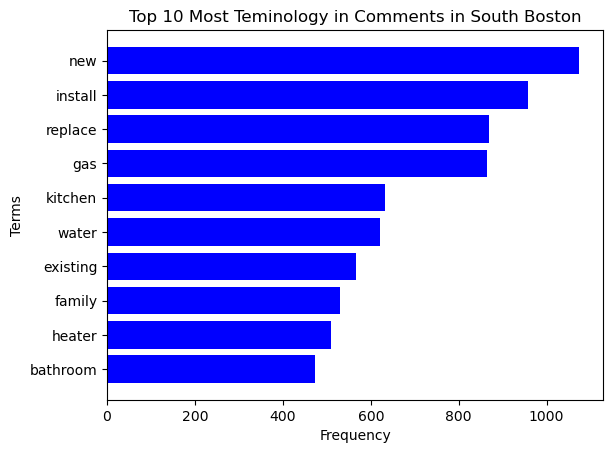

In [ ]:
# Convert all comments to strings (handling NaN values safely)
merged_df['comments'] = merged_df['comments'].astype(str)

# Filter comments from Dorchester and South Boston
comments_df_SouBost = merged_df[merged_df['MAILING_NEIGHBORHOOD'].isin(['South Boston'])][['MAILING_NEIGHBORHOOD', 'comments']]

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
comments_df_SouBost['sentiment'] = comments_df_SouBost['comments'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Display the sentiment scores
print(comments_df_SouBost[['MAILING_NEIGHBORHOOD', 'comments', 'sentiment']].head())

# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(comments_df_SouBost['comments'])

# Singular Value Decomposition for TF-IDF
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10, random_state=42)
svd_matrix = svd_model.fit_transform(tfidf_matrix)

# Plot the 10 most frequent words in the TF-IDF transformed matrix
terms = tfidf_vectorizer.get_feature_names_out()
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking_sorted = ranking.sort_values('rank', ascending=False)
top_terms = ranking_sorted.head(10)

fig, ax = plt.subplots()
ax.barh(top_terms['term'], top_terms['rank'], color='blue')
ax.set_xlabel('Frequency')
ax.set_ylabel('Terms')
ax.set_title('Top 10 Most Teminology in Comments in South Boston')
plt.gca().invert_yaxis()
plt.show()

   MAILING_NEIGHBORHOOD                                           comments  \
14           Dorchester  Amendment to ERT759370. Finishing the basement...   
17           Dorchester  Bathroom &; Kitchen floor reframing Plans: Thi...   
18           Dorchester  Amendment to ALT788317. Bathroom &; Kitchen fl...   
19           Dorchester  Amendment to ERT815362 as per new foundation p...   
32         South Boston  Amending permit ERT771694 to include these 24v...   

    sentiment  
14     0.2960  
17     0.0000  
18     0.0000  
19     0.0000  
32    -0.5859  


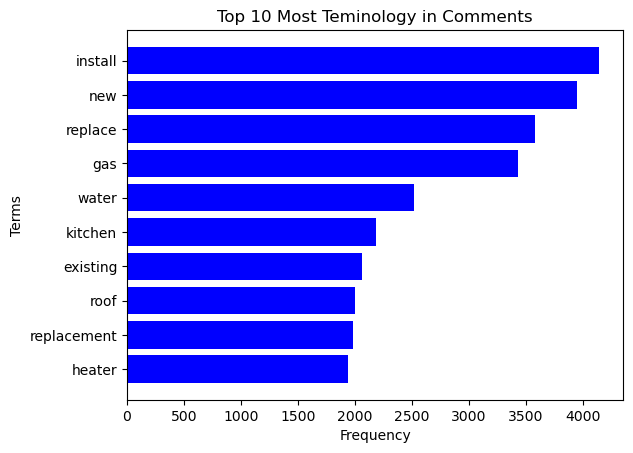

In [ ]:
# Convert all comments to strings (handling NaN values safely)
merged_df['comments'] = merged_df['comments'].astype(str)

# Filter comments from Dorchester and South Boston
comments_df = merged_df[merged_df['MAILING_NEIGHBORHOOD'].isin(['South Boston', 'Dorchester'])][['MAILING_NEIGHBORHOOD', 'comments']]

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
comments_df['sentiment'] = comments_df['comments'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Display the sentiment scores
print(comments_df[['MAILING_NEIGHBORHOOD', 'comments', 'sentiment']].head())

# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(comments_df['comments'])

# Singular Value Decomposition for TF-IDF
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10, random_state=42)
svd_matrix = svd_model.fit_transform(tfidf_matrix)

# Plot the 10 most frequent words in the TF-IDF transformed matrix
terms = tfidf_vectorizer.get_feature_names_out()
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking_sorted = ranking.sort_values('rank', ascending=False)
top_terms = ranking_sorted.head(10)

fig, ax = plt.subplots()
ax.barh(top_terms['term'], top_terms['rank'], color='blue')
ax.set_xlabel('Frequency')
ax.set_ylabel('Terms')
ax.set_title('Top 10 Most Teminology in Comments')
plt.gca().invert_yaxis()
plt.show()

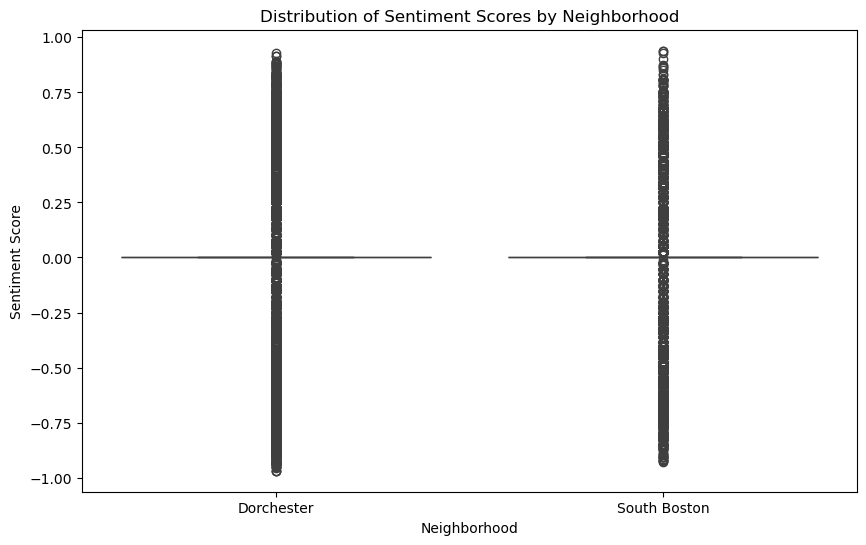

In [ ]:
# Plotting sentiment score distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='MAILING_NEIGHBORHOOD', y='sentiment', data=comments_df)
plt.title('Distribution of Sentiment Scores by Neighborhood')
plt.ylabel('Sentiment Score')
plt.xlabel('Neighborhood')
plt.show()

## Word cloud visualization

Word cloud to visualize the most common words in the comments, which can give a quick visual understanding of key themes.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wilbertlimson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

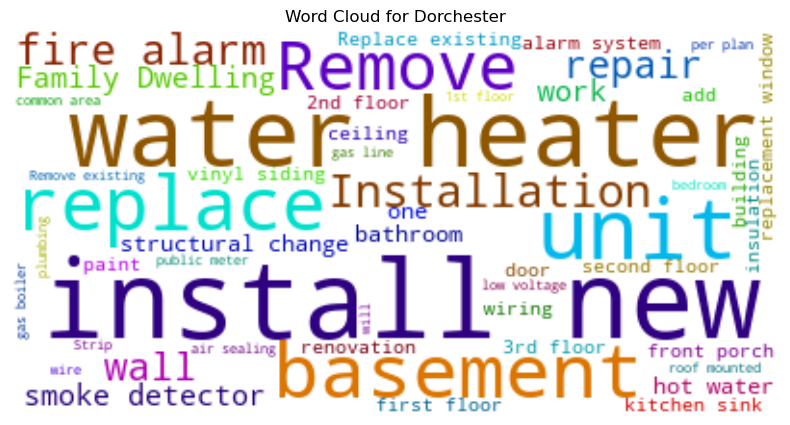

In [ ]:
# Generate a word cloud image for each neighborhood
for neighborhood in ['Dorchester']:
    subset = comments_df[comments_df['MAILING_NEIGHBORHOOD'] == neighborhood]
    text = " ".join(review for review in subset.comments)

    # Define a function to create colors randomly
    def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        h = random.randint(0, 360)
        s = int(100.0 * 255.0 / 255.0)
        l = int(100.0 * random.randint(60, 120) / 255.0)
        return f"hsl({h}, {s}%, {l}%)"

    # Create a word cloud with random colors
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=50,
                          color_func=random_color_func, mode="RGB").generate(text)

    # Display the generated image
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {neighborhood}")
    plt.show()


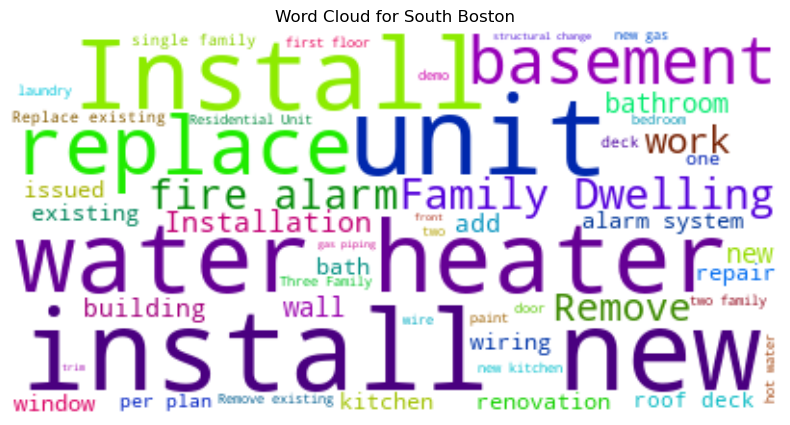

In [ ]:
# Define a function to create colors randomly
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = random.randint(0, 360)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * random.randint(60, 120) / 255.0)
    return f"hsl({h}, {s}%, {l}%)"

# Generate a word cloud image for each neighborhood
for neighborhood in ['South Boston']:
    subset = comments_df[comments_df['MAILING_NEIGHBORHOOD'] == neighborhood]
    text = " ".join(review for review in subset.comments)

    # Create a word cloud with random colors
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white",
                          max_words=50, color_func=random_color_func).generate(text)

    # Display the generated image
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {neighborhood}")
    plt.show()

Detailed Sentiment Breakdown: Break down the sentiment of comments more finely into positive, neutral, and negative categories, and provide counts or proportions.

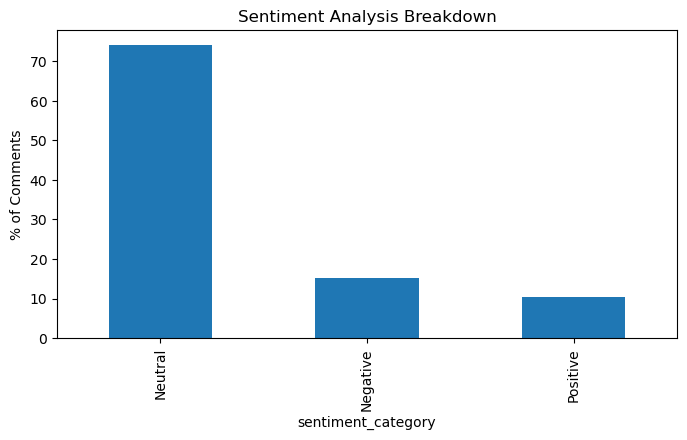

In [ ]:
comments_df['sentiment_category'] = pd.cut(comments_df['sentiment'],
                                            bins=[-1, -0.01, 0.01, 1],
                                            labels=["Negative", "Neutral", "Positive"])
sentiment_counts = comments_df['sentiment_category'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 4))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Analysis Breakdown')
plt.ylabel('% of Comments')
plt.show()


In [ ]:
# Display some sample negative comments
negative_comments = comments_df[comments_df['sentiment_category'] == 'Negative']
print("Sample Negative Comments:")
print(negative_comments[['comments', 'sentiment']].sample(5))

Sample Negative Comments:
                                                 comments  sentiment
220850  Replacement gas furnace, and gas on demand wat...    -0.1280
146312  NEW CONSTRUCTION REQUIRES THE INSTALLATION OF ...    -0.7096
320181  Repair water damage: clear out building,remove...    -0.8885
330753  Installation of 18 Roof mounted solar panels; ...    -0.4466
276172  Replacement of steam fired gas boiler in basement    -0.5574


In [ ]:
print(negative_comments[['comments']].sample(5))

                                                                                                                                                                                                                                                                        comments
19608                                                                                                                                                                                                             Legalize;occupancy as One Family dwelling. No work to be done.
157931                                                                                                                                                                                 120 volts smoke alarms will be install on every bedrooms and common area within the unit.
143097                                                                  AFA Protective Systems, Inc. is installing a Napco Cellular Fire Alarm Communicator as a \npart of central st

In [ ]:
# Display some sample positive
pd.set_option('display.max_colwidth', None)

positive_comments = comments_df[comments_df['sentiment_category'] == 'Positive']
print("\nSample Positive Comments:")
print(positive_comments[['comments', 'sentiment']].sample(5))


Sample Positive Comments:
                                                                                                                                                                       comments  \
51129                                                                Single Family Dwelling\n\nAlt413821 issued 1/24/2017, SF233892 issued 5/9/2013 &; SF212472 issued 1/9/2013   
182709                                                                                                                                                  Install security system   
334942                                                                REMOVE & REPLACE 9 WINDOWS; LIKE FOR LIKE SIZE; NO STRUCTURAL CHANGES ****WORK BEING DONE IN UNIT 2****\n   
7668    Elec app.  Per BPDA approval 9-24-20, replace signs for Target.  East elev:  signs 01,03, 04, 05.    North elev:  signs 02 and 06.  Ground sign 07 reface tenant panel.   
28511                                                   confirm occupancy as a

In [ ]:
print(positive_comments[['comments']].sample(5))

                                                                                                                                                    comments
18459   Replace roof deck removed for EPDM roof replacement. Deck to be same size and location as original. Photographs and original short form are attached
324647                                                replace the previously installed gutter over the door and install a new downspout to reach the ground.
7722     Extend upstairs dwelling unit with rooftop construction of penthouse with roof deck. Nominal fee requested pending Zoning Board of Appeals hearing.
118595                                                                                                        Inspection for a reconnection.  Restore power.
108014                                                                 Replace lighting with energy efficient fixtures at 179 Washington St.-Raphael Lajara.


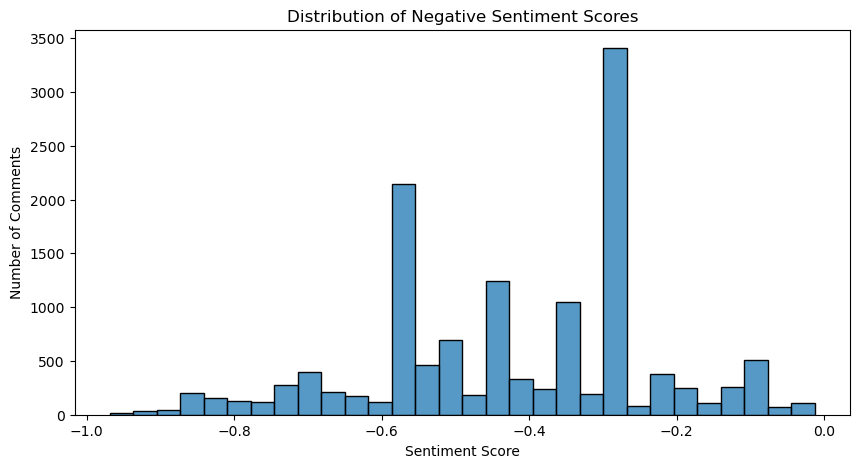

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(negative_comments['sentiment'], bins=30, kde=False)
plt.title('Distribution of Negative Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Comments')
plt.show()

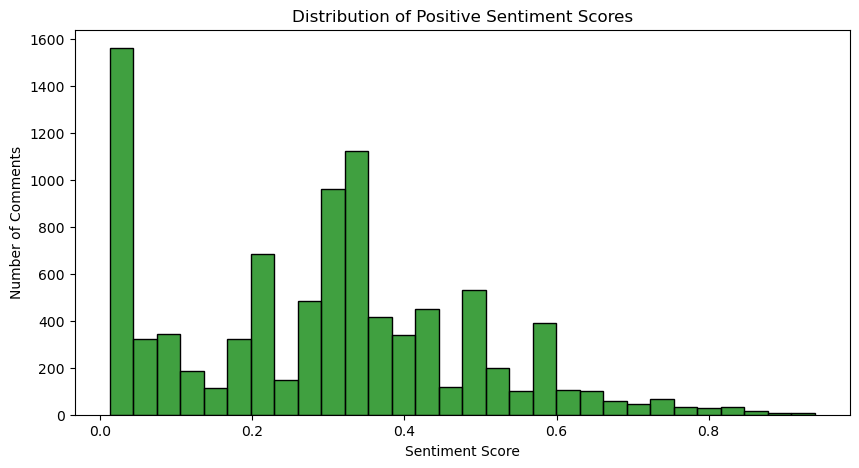

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(positive_comments['sentiment'], bins=30, kde=False, color='green')
plt.title('Distribution of Positive Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Comments')
plt.show()

N-Gram Analysis: After examining individual words, look at the most common bi-grams or tri-grams to get a sense of the phrases used in comments.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_grams(corpus, ngram_range, top_n):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_phrases = vec.transform(corpus)
    sum_phrases = bag_of_phrases.sum(axis=0)
    phrases_freq = [(phrase, sum_phrases[0, idx]) for phrase, idx in vec.vocabulary_.items()]
    phrases_freq = sorted(phrases_freq, key=lambda x: x[1], reverse=True)
    return phrases_freq[:top_n]

# Top 10 bi-grams
top_bi_grams = get_top_n_grams(comments_df['comments'], (2,2), 10)
print(top_bi_grams)

# Top 10 tri-grams
top_tri_grams = get_top_n_grams(comments_df['comments'], (3,3), 10)
print(top_tri_grams)


[('install new', 7829), ('water heater', 4334), ('family dwelling', 2542), ('replace existing', 1877), ('remove replace', 1834), ('smoke detectors', 1797), ('hot water', 1758), ('structural changes', 1732), ('remove existing', 1463), ('2nd floor', 1445)]
[('hot water heater', 752), ('windows structural changes', 593), ('replace water heater', 563), ('install new roof', 562), ('replacement windows structural', 556), ('occupancy family dwelling', 541), ('gas water heater', 529), ('add public meter', 491), ('confirm occupancy family', 463), ('install replacement windows', 424)]


In [ ]:
# Preparing the text data
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(comments_df['comments'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(count_data)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx+1))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda, count_vectorizer)


Topic 1:
[('water', 8427.441813180005), ('replace', 8240.243196765825), ('heater', 4548.755310324292), ('kitchen', 3911.714365912138), ('install', 3804.212202578732), ('boiler', 2790.9495011568247), ('bathroom', 2727.0300816743156), ('new', 2701.322407135578), ('sink', 2150.1682815834984), ('fixtures', 2071.53822264289)]
Topic 2:
[('install', 9109.241691354693), ('roof', 7822.71303349908), ('issued', 4548.198990509759), ('new', 3246.1655013536133), ('family', 2710.8401703549416), ('strip', 2499.1978244808374), ('existing', 2474.7874897847723), ('structural', 2257.1585593126365), ('shingles', 2189.4402112067996), ('panels', 2052.8375581276528)]
Topic 3:
[('new', 12077.252622405485), ('floor', 10321.969168206626), ('replace', 8148.488671572066), ('existing', 6353.804564108676), ('kitchen', 5759.870945081426), ('install', 5320.9369982315675), ('remove', 5215.806277906748), ('repair', 4464.214997834075), ('bathroom', 3538.36489305035), ('plumbing', 3049.655881186019)]
Topic 4:
[('new', 460

In [ ]:
# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_phrases = vec.transform(corpus)
    sum_phrases = bag_of_phrases.sum(axis=0)
    phrases_freq = [(phrase, sum_phrases[0, idx]) for phrase, idx in vec.vocabulary_.items()]
    phrases_freq = sorted(phrases_freq, key=lambda x: x[1], reverse=True)
    return phrases_freq[:n]

# Top 10 bi-grams
top_bi_grams = get_top_ngrams(comments_df['comments'], ngram_range=(2, 2), n=10)
print("Top 10 bi-grams:", top_bi_grams)

# Top 10 tri-grams
top_tri_grams = get_top_ngrams(comments_df['comments'], ngram_range=(3, 3), n=10)
print("Top 10 tri-grams:", top_tri_grams)


Top 10 bi-grams: [('install new', 7829), ('water heater', 4334), ('family dwelling', 2542), ('replace existing', 1877), ('remove replace', 1834), ('smoke detectors', 1797), ('hot water', 1758), ('structural changes', 1732), ('remove existing', 1463), ('2nd floor', 1445)]
Top 10 tri-grams: [('hot water heater', 752), ('windows structural changes', 593), ('replace water heater', 563), ('install new roof', 562), ('replacement windows structural', 556), ('occupancy family dwelling', 541), ('gas water heater', 529), ('add public meter', 491), ('confirm occupancy family', 463), ('install replacement windows', 424)]


#Readability analysis on the text, how well it will be understood

In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 532.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.0 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


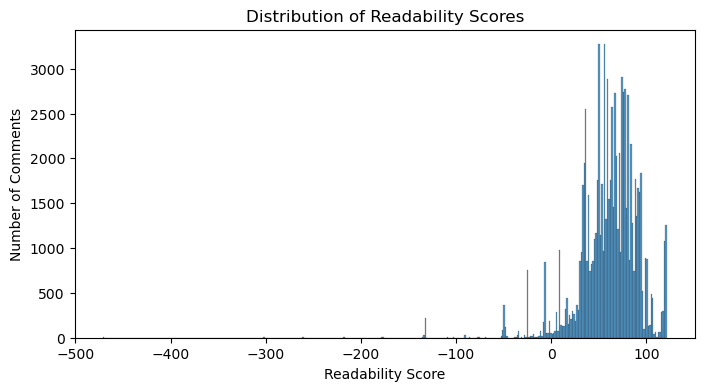

In [ ]:
import textstat

comments_df['readability_score'] = comments_df['comments'].apply(textstat.flesch_reading_ease)

plt.figure(figsize=(8, 4))
sns.histplot(comments_df['readability_score'], kde=False)
plt.title('Distribution of Readability Scores')
plt.xlabel('Readability Score')
plt.ylabel('Number of Comments')
plt.show()